In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', True)
import jax.numpy as jnp
import jax.scipy.stats as jss

from data import get_posteriors
from data import get_injections

from bilby_util import convert_bilby_uniform_prior

from models import truncnorm
from models import iso_gauss_spin_tilt
from models import log_powerlaw_redshift
from pixelpop.models.gwpop_models import PowerlawPlusPeak_MassRatio
from pixelpop.models.gwpop_models import BrokenPowerlawPlusTwoPeaks_PrimaryMass

from likelihood import taper
from likelihood import shape_ln_likelihood_and_variance

from flows import default_flow
from variational import fit
from variational import estimate_convergence

%load_ext autoreload
%autoreload 2

/home/noah.wolfe/.conda/envs/seqpop/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
posteriors, events = get_posteriors()

100%|██████████| 153/153 [01:23<00:00,  1.84it/s]


In [3]:
jnp.min(jnp.max(posteriors['mass_1_source'] * posteriors['mass_ratio'], axis=1))

Array(6.96051393, dtype=float64)

In [4]:
posteriors['mass_1'] = posteriors.pop('mass_1_source')

In [5]:
injections = get_injections()

In [6]:
injections['mass_1'] = injections.pop('mass_1_source')

In [7]:
injections['total_generated'] = injections.pop('total')

## simple kick distribution

In [8]:
from flows import bound_from_unbound
from flowjax.distributions import StandardNormal
from flowjax.bijections import RationalQuadraticSpline
from flowjax.flows import coupling_flow

default_kwargs = dict(
    key=jax.random.key(1),
    base_dist=StandardNormal(shape=(1,)),
    invert=False,
    nn_depth=1,
    nn_width=5,
    flow_layers=1,
    cond_dim=1
)

transformer = RationalQuadraticSpline(knots=5, interval=(-5, 5))
cos_tau_prior_init = coupling_flow(transformer=transformer, **default_kwargs)
cos_tau_prior_init = bound_from_unbound(cos_tau_prior_init, [[-1, 1]])

In [9]:
from flows import count_params
count_params(cos_tau_prior_init)

112

In [10]:
def calc_cos_tau_from_kick(u, cos_theta, cos_phi):
    theta = jnp.arccos(cos_theta)
    numer = u * cos_theta + 1
    denom = (u * jnp.sin(theta) * cos_phi)**2 + numer**2
    return numer / jnp.sqrt(denom)

In [11]:
import equinox as eqx
import optax
from paramax import NonTrainable
from jax_tqdm import scan_tqdm

def train_cos_tau_prior(
    key,
    flow,
    steps,
    optimizer=None,
    batch_size=1,
):
    params, static = eqx.partition(
        pytree=flow,
        filter_spec=eqx.is_inexact_array,
        is_leaf=lambda leaf: isinstance(leaf, NonTrainable),
    )

    def get_batch(key):
        key, subkey = jax.random.split(key)
        cos_phi = jax.random.uniform(subkey, shape=(batch_size,)) * 2 - 1

        key, subkey = jax.random.split(key)
        x = jax.random.uniform(subkey, shape=(batch_size,))
        cos_theta = 1 - 2 * x

        key, subkey = jax.random.split(key)
        u = jax.random.uniform(subkey, shape=(batch_size,)) * 2

        cos_tau = calc_cos_tau_from_kick(u, cos_theta, cos_phi)

        return cos_tau[:, None], u[:, None]

    def loss_fn(params, key, step):
        flow = eqx.combine(params, static)
        batch = get_batch(key)
        log_q = jax.vmap(lambda x: flow.log_prob(*x))(batch)
        return -jnp.mean(log_q)
   
    state = optimizer.init(params)

    @scan_tqdm(steps, desc='train')
    @eqx.filter_jit
    def update(carry, step):
        key, params, state = carry
        key, _key = jax.random.split(key)
        loss, grad = eqx.filter_value_and_grad(loss_fn)(params, _key, step)
        updates, state = optimizer.update(grad, state, params)
        params = eqx.apply_updates(params, updates)
        return (key, params, state), loss

    (key, params, state), losses = jax.lax.scan(
        update, (key, params, state), jnp.arange(steps),
    )
    flow = eqx.combine(params, static)

    return flow, losses


In [12]:
lr = 1e-3
steps = 10_000

learning_rate = optax.warmup_cosine_decay_schedule(
    init_value=lr,
    peak_value=lr,
    warmup_steps=0,
    decay_steps=steps,
    end_value=lr
)

optimizer = optax.adam(learning_rate=learning_rate)

cos_tau_prior, loss = train_cos_tau_prior(jax.random.key(12), cos_tau_prior_init, steps, optimizer, batch_size=10_000)

train: 100%|██████████| 10000/10000 [00:12<00:00, 793.49it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

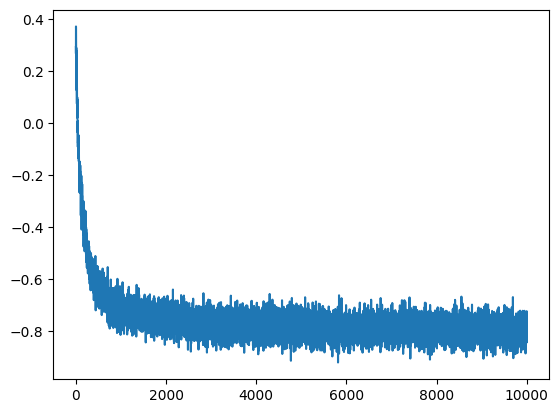

In [13]:
from util import plot_loss
plot_loss(loss)

In [14]:
samps = jax.vmap(lambda k: cos_tau_prior.sample(k, condition=jnp.array([0.5])))(jax.random.split(jax.random.key(1), 1_000)).squeeze()

In [15]:
samps2 = jax.vmap(lambda k: cos_tau_prior.sample(k, condition=jnp.array([0.001])))(jax.random.split(jax.random.key(1), 1_000)).squeeze()

In [16]:
samps2 = jax.vmap(lambda k: cos_tau_prior.sample(k, condition=jnp.array([2])))(jax.random.split(jax.random.key(1), 1_000)).squeeze()

In [17]:
samps10 = jax.vmap(lambda k: cos_tau_prior.sample(k, condition=jnp.array([10])))(jax.random.split(jax.random.key(1), 1_000)).squeeze()

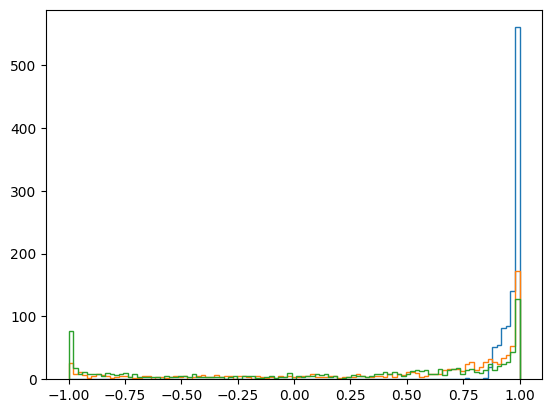

In [18]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()
ax.hist(samps, histtype='step', bins=bins);
ax.hist(samps2, histtype='step', bins=bins);
ax.hist(samps10, histtype='step', bins=bins);


$$p(\cos \tau | \Lambda) = \int d \vec{u} \, p(\tau | \vec{u}) p(\vec{u} | \Lambda) $$

with 

$$ p(\cos \tau | \vec{u}) = \delta (\cos \tau - \cos \tau(\vec{u})) $$

where

$$ \cos^2 \tau = \frac{ (u \cos \theta + 1)^2 }{ u^2 \sin^2 \theta \cos^2 \phi + (u \cos \theta + 1)^2 }

In [19]:
test_u = jnp.linspace(0, 2, 500)
test_ct = jnp.linspace(-1 + 1e-10, 1 - 1e-10, 500)

uu, cc = jnp.meshgrid(test_u, test_ct, indexing='ij') # (Nu, Nc)

vec_f = jnp.vectorize(
    lambda a, b: cos_tau_prior.log_prob(b, a),             # each a,b will be shape (1,)
    signature="(1),(1)->()"           # declare the core/event dim
)

log_probs = vec_f(uu[..., None], cc[..., None])

In [79]:
from interpax import Interpolator2D

interp = Interpolator2D(test_u, test_ct, log_probs, method='linear')

In [20]:
def tilts_marg_over_kicks(cos_tau, mu_kick, sigma_kick):
    u = jnp.linspace(0, 2, 500)

    log_p_cos_tau_given_u = jax.vmap(
        lambda x: cos_tau_prior.log_prob(cos_tau, condition=x)
    )(u[:, None]).squeeze()

    #log_p_cos_tau_given_u = interp(
    #    jnp.tile(cos_tau, len(u)),
    #    u
    #)

    p_u = jax.vmap(
        lambda x: truncnorm(
            jnp.log(x), mu=mu_kick, sigma=sigma_kick, high=2, low=0
        )
    )(u)

    integrand = jnp.exp(log_p_cos_tau_given_u) * p_u

    return jnp.trapezoid(integrand, u)

In [21]:
len(injections['prior'])

1065922

In [29]:
def tilt_model(dataset, parameters):
    
    def fn(cos_tau):
        return tilts_marg_over_kicks(
            jnp.array([cos_tau]),
            parameters['mu_kick'],
            parameters['sigma_kick']
        )

    in_shape = dataset['cos_tilt_1'].shape

    p_cos_tau_1 = jax.lax.map(
        fn, dataset['cos_tilt_1'].flatten(), batch_size=100 #10_000
    ).reshape(in_shape)
    p_cos_tau_2 = jax.lax.map(
        fn, dataset['cos_tilt_2'].flatten(), batch_size=100 #10_000
    ).reshape(in_shape)

    return p_cos_tau_1 * p_cos_tau_2 

In [ ]:
@eqx.filter_jit
def tilt_model(dataset, parameters):
    mu, sig = parameters['mu_kick'], parameters['sigma_kick']

    # Base op: takes a scalar, wraps to length-1 array for the kernel.
    def base_scalar(cos_tau_scalar):
        return tilts_marg_over_kicks(jnp.array([cos_tau_scalar]), mu, sig)

    # Shape-polymorphic vmap: handles 1D or 2D without flatten/reshape.
    def vmap_over(x):
        if x.ndim == 1:
            return jax.lax.map(base_scalar, x, batch_size=10_000) #jax.vmap(base_scalar, in_axes=0)(x)
        elif x.ndim == 2:
            return jax.lax.map(
                lambda r: jax.lax.map(base_scalar, r, batch_size=10), #jax.vmap(base_scalar)(r),
                x,
                batch_size=1
            )
            #return jax.lax.map(jax.vmap(base_scalar, in_axes=0),    ) #jax.vmap(jax.vmap(base_scalar, in_axes=0), in_axes=0)(x)
        else:
            raise ValueError(f"Expected 1D or 2D, got {x.shape}")

    #vm = jax.jit(vmap_over)

    p1 = vmap_over(dataset['cos_tilt_1'])
    p2 = vmap_over(dataset['cos_tilt_2'])

    return p1 * p2

In [60]:
def model_kick(dataset, parameters):
    lam_tilde_0 = parameters['lam_tilde_0']
    lam_tilde_1 = parameters['lam_tilde_1']
    lam_tilde_2 = parameters['lam_tilde_2']

    norm = lam_tilde_0 + lam_tilde_1 + lam_tilde_2
    parameters['lam0'] = lam_tilde_0 / norm
    parameters['lam1'] = lam_tilde_1 / norm
    parameters['lam2'] = lam_tilde_2 / norm

    #p_m1qzmag = bplm1q_plz_truncnormmag(dataset, parameters)

    log_p_m1 = BrokenPowerlawPlusTwoPeaks_PrimaryMass(
        dataset,
        alpha_1=parameters['alpha1'],
        alpha_2=parameters['alpha2'],
        mmin=parameters['mmin'],
        break_mass=parameters['mbreak'],
        delta_m_1=parameters['delta_m'],
        lam_fractions=[
            parameters['lam0'],
            parameters['lam1'],
            parameters['lam2']
        ],
        mpp_1=parameters['mpp1'],
        sigpp_1=parameters['sigpp1'],
        mpp_2=parameters['mpp2'],
        sigpp_2=parameters['sigpp2'],
    )
    p_m1 = jnp.exp(log_p_m1)

    log_p_q = PowerlawPlusPeak_MassRatio(
        dataset,
        slope=parameters['beta'],
        minimum=parameters['mmin'],
        delta_m=parameters['delta_m']
    )
    p_q = jnp.exp(log_p_q)

    log_p_z = log_powerlaw_redshift(dataset, parameters)
    p_z = jnp.exp(log_p_z)

    p_a1 = truncnorm(
        dataset['a_1'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )
    p_a2 = truncnorm(
        dataset['a_2'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )

    p_tilt = tilt_model(dataset, parameters)

    return p_m1 * p_q * p_z * p_a1 * p_a2 * p_tilt

In [61]:
param_keys, bounds, log_prior = convert_bilby_uniform_prior('./kick.prior')

In [62]:
maximum_variance = 1

def log_likelihood(parameters):
    parameters = dict(zip(param_keys, parameters))
    lkl, var, _, _, _ = shape_ln_likelihood_and_variance(
        posteriors, injections, model_kick, parameters
    )
    return lkl, var


def log_posterior(parameters):
    lkl, var = log_likelihood(parameters)
    return lkl + taper(maximum_variance, var) + log_prior(parameters)

In [66]:
import pickle

with open('./posteriors.pkl', 'wb') as f:
    pickle.dump(posteriors, f)

with open('./injections.pkl', 'wb') as f:
    pickle.dump(injections, f)

In [63]:
flow_init = default_flow(jax.random.key(1), bounds)

In [64]:
flow, loss = fit(jax.random.key(2), flow_init, log_posterior, steps=10)

2025-09-29 16:52:56.680611: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 6.87GiB (7377510372 bytes) by rematerialization; only reduced to 10.87GiB (11672564255 bytes), down from 10.99GiB (11798189423 bytes) originally
2025-09-29 16:53:37.633053: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.91GiB (rounded to 11712494336)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-09-29 16:53:37.633677: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ___________________________________________________________________________________________________*
E0929 16:53:37.633705 1784971 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while 

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 11712494088 bytes.

## old

In [14]:
def model(dataset, parameters):
    lam_tilde_0 = parameters['lam_tilde_0']
    lam_tilde_1 = parameters['lam_tilde_1']
    lam_tilde_2 = parameters['lam_tilde_2']

    norm = lam_tilde_0 + lam_tilde_1 + lam_tilde_2
    parameters['lam0'] = lam_tilde_0 / norm
    parameters['lam1'] = lam_tilde_1 / norm
    parameters['lam2'] = lam_tilde_2 / norm

    #p_m1qzmag = bplm1q_plz_truncnormmag(dataset, parameters)

    log_p_m1 = BrokenPowerlawPlusTwoPeaks_PrimaryMass(
        dataset,
        alpha_1=parameters['alpha1'],
        alpha_2=parameters['alpha2'],
        mmin=parameters['mmin'],
        break_mass=parameters['mbreak'],
        delta_m_1=parameters['delta_m'],
        lam_fractions=[
            parameters['lam0'],
            parameters['lam1'],
            parameters['lam2']
        ],
        mpp_1=parameters['mpp1'],
        sigpp_1=parameters['sigpp1'],
        mpp_2=parameters['mpp2'],
        sigpp_2=parameters['sigpp2'],
    )
    p_m1 = jnp.exp(log_p_m1)

    log_p_q = PowerlawPlusPeak_MassRatio(
        dataset,
        slope=parameters['beta'],
        minimum=parameters['mmin'],
        delta_m=parameters['delta_m']
    )
    p_q = jnp.exp(log_p_q)

    log_p_z = log_powerlaw_redshift(dataset, parameters)
    p_z = jnp.exp(log_p_z)

    p_a1 = truncnorm(
        dataset['a_1'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )
    p_a2 = truncnorm(
        dataset['a_2'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )

    p_tilt = iso_gauss_spin_tilt(
        dataset,
        xi_spin=parameters['xi_spin'],
        sigma_spin=parameters['sigma_spin'],
        mu_spin=parameters['mu_spin']
    )

    return p_m1 * p_q * p_z * p_a1 * p_a2 * p_tilt

In [15]:
maximum_variance = 1

def log_likelihood(parameters):
    parameters = dict(zip(param_keys, parameters))
    lkl, var, _, _, _ = shape_ln_likelihood_and_variance(
        posteriors, injections, model, parameters
    )
    return lkl, var


def log_posterior(parameters):
    lkl, var = log_likelihood(parameters)
    return lkl + taper(maximum_variance, var) + log_prior(parameters)

In [16]:
flow_init = default_flow(jax.random.key(1), bounds)

In [19]:
flow, loss = fit(jax.random.key(2), flow_init, log_posterior, steps=1_000)

train: 100%|██████████| 1000/1000 [00:05<00:00, 174.15it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

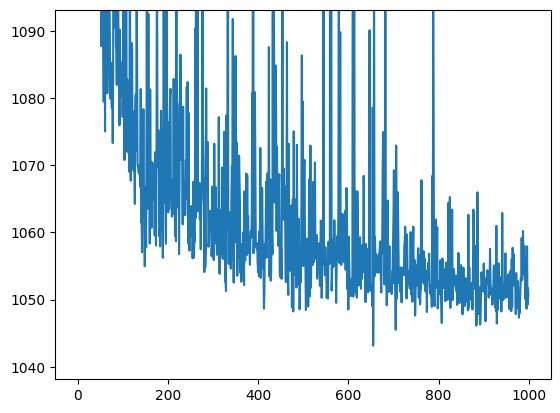

In [20]:
from util import plot_loss

plot_loss(loss, zoom=True)

In [22]:
samples, log_q = jax.vmap(flow.sample_and_log_prob)(jax.random.split(jax.random.key(3), 10_000))

In [23]:
log_p = jax.lax.map(log_posterior, samples, batch_size=10)

In [24]:
stats = estimate_convergence(log_p, log_q)

In [26]:
stats['kss'], stats['eff']

(array(0.68617368), Array(0.02536088, dtype=float64))